# Lab 9

# 0. Intro
Welcome to Lab 9!

You're probably exhausted from midterm season, so it's a great time to let a machine learn for you!  This lab covers an important machine learning topic: multiple linear regression, or in less fancy terminology, "how to predict a number using multiple sources of information that are numbers."  We'll see how to predict the selling price of a house, which might come in handy if you ever sell your own house.

#### Administrative details
Lab submissions are due by **Friday, March 18 at 7:00 PM**.

As usual, if you attend lab section and make a good effort but don't finish during the 2 hours, let your TA know, and you'll get full credit for the lab.  If you do that, please finish the lab on your own time (or in office hours, of course).

In [1]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# This line loads a small addition to the minimize function for this lab.
from lab09_minimize import *

# These lines load the tests.
from client.api.assignment import load_assignment 
lab09 = load_assignment('lab09.ok')

Assignment: Lab 9
OK, version v1.5.1



# 1. Predicting House Prices
For many people, their house is their most valuable asset, so selling a house is an important event.  When deciding on a price to sell at, an owner wants to ask for the highest price at which she can sell the house in a reasonable amount of time.  Owners often ask real-estate agents to set the price, and these agents use their knowledge of the house and the local housing market to guess at the right price.

Let's see if we can do that with a computer instead, by mimicking prices other owners set for *similar* houses.  Since we're predicting a price, which is a number, this is a *regression* task.  And we want to use multiple pieces of information about a house to predict its price, so it's a *multiple* regression task.  Since we've learned about linear regression in this class, we'll do multiple *linear* regression.

The table `house_prices.csv` contains the listed prices of 566 houses sold in Southern California in 2009.    For each house, it also records several of the house's attributes:
* how big it is (in square feet),
* the number of bedrooms and bathrooms it has, and
* the house's location.

The locations are represented in a peculiar way that helps us use them in linear regression: There is a column for each potential location, and each house has a 1 in the column for its location and a 0 for the other location columns.  That's a common trick; some people call these kinds of columns "dummy variables".

The data come from researchers at Cal Poly; the original dataset can be found [here](https://wiki.csc.calpoly.edu/datasets/wiki/Houses).

Run the next cell to load and view the table.

In [2]:
house_prices = Table.read_table("house_prices.csv")
house_prices.show(10)

Price,Bedrooms,Bathrooms,Size,Santa Maria-Orcutt (0/1),Paso Robles (0/1),Atascadero (0/1),Nipomo (0/1),Arroyo Grande (0/1),Lompoc (0/1),Los Osos (0/1),Grover Beach (0/1),Paso Robles (0/1),San Miguel (0/1)
232600,3,3,1582,1,0,0,0,0,0,0,0,0,0
119000,1,1,900,1,0,0,0,0,0,0,0,0,0
220000,3,2,1112,0,0,0,1,0,0,0,0,0,0
169900,4,2,1500,1,0,0,0,0,0,0,0,0,0
186900,3,1,912,0,0,0,0,0,1,0,0,0,0
240000,4,2,1460,1,0,0,0,0,0,0,0,0,0
225000,3,2,1144,1,0,0,0,0,0,0,0,0,0
469000,3,2,1827,0,0,0,0,0,0,0,1,0,0
179000,3,2,1398,1,0,0,0,0,0,0,0,0,0
205000,3,2,1146,1,0,0,0,0,0,0,0,0,0


The idea is to use the attributes of each house to predict its price.  We'll take our training data, which has both attributes and actual prices, and find a model that produces good predictions for that data.  Then, if we wanted to list a house ourselves, we could predict our own house's price and use our prediction as our price instead of consulting an expert.  Of course, that wouldn't be a good idea if the model weren't very accurate, so we'll need to measure that, too.

Before we run any regressions, we need to think about how we'll evaluate the models we produce.  That means checking how accurate its predictions are -- something like the mean squared error or R-squared.

As we've seen in lecture, you don't get an accurate estimate of a model's predictive performance if you test it on the data you use to train it.  It's easy for a model to predict well on its training data -- remember linear regression with 2 data points, or 1-nearest-neighbor classification -- even if it doesn't make any sense.  The real test is how the model performs on other data from the population for which we're interested in making predictions.

So we need to hold out a *test set* that we'll only use to *test* the accuracy of the models we make, not to *train* them.

**Question 1.1.** Split `house_prices` into two separate tables called `train` and `test`.  `train` should include the first 300 rows from `house_prices`.  `test` should contain all the other rows of `house_prices`.  `house_prices` is currently in random order, so `train` and `test` will end up being two disjoint random samples from `house_prices`.

*Hint:* If `t` is a table, then `t.take(np.arange(300))` is a table consisting of the first 300 rows of `t`.  `t.exclude(np.arange(300))` is a table consisting of all the rows of `t` *except* the first 300.

In [4]:
# Divide up house_prices into train and test tables as described above.
train = house_prices.take(np.arange(300))
test = house_prices.exclude(np.arange(300))
train.show(3)
test.show(3)

Price,Bedrooms,Bathrooms,Size,Santa Maria-Orcutt (0/1),Paso Robles (0/1),Atascadero (0/1),Nipomo (0/1),Arroyo Grande (0/1),Lompoc (0/1),Los Osos (0/1),Grover Beach (0/1),Paso Robles (0/1),San Miguel (0/1)
232600,3,3,1582,1,0,0,0,0,0,0,0,0,0
119000,1,1,900,1,0,0,0,0,0,0,0,0,0
220000,3,2,1112,0,0,0,1,0,0,0,0,0,0


Price,Bedrooms,Bathrooms,Size,Santa Maria-Orcutt (0/1),Paso Robles (0/1),Atascadero (0/1),Nipomo (0/1),Arroyo Grande (0/1),Lompoc (0/1),Los Osos (0/1),Grover Beach (0/1),Paso Robles (0/1),San Miguel (0/1)
129900,3,1,1042,1,0,0,0,0,0,0,0,0,0
199900,4,2,1338,0,0,0,0,0,1,0,0,0,0
449900,4,3,3035,0,0,0,0,0,1,0,0,0,0


In [5]:
_ = lab09.grade("q11")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



Okay, on to regression.

We're going to focus on using and interpreting multiple regression rather than computing models.  So we've written code below that will compute least-squares coefficients for you.  Peruse the code below, but the only thing you'll need to do with it is *calling* the functions it defines.  That means you should read the *documentation* (the stuff in triple-double quotes) but you don't need to read the *implementations* (the actual code in the body of each function).

Run the next cell to load that code:

In [7]:
# Just run this cell.  You should also at least read the
# documentation for the functions (the stuff inside the
# triple-double-quotes that describes what each function
# does), since you'll need to call them soon.

def predict_all(features_table, coefficients):
    """
    Given a table of features called features_table and some coefficients,
    produces linear predictions for each row of features_table.
    
    features_table should be a table with one column for each feature
    being used to predict.  Each row represents a house in the task
    we're doing in this lab.
    
    coefficients should be an array with one element for each column in
    features_table, like the coefficients computed by the function
    least_squares_coefficients.
    
    Returns an array of predictions, one for each row of features_table.
    
    For example, in the house price prediction task we're working on in
    this lab, each row of data is the features of one house sale, like
    the number of bedrooms or the size of the house.  To make a
    prediction for the price of a house, we multiply each of these
    features by the corresponding coefficient in the coefficients
    array, then sum the results.
    
    An even more detailed example: Suppose we have just one house whose
    price we want to predict, and two features, Bedrooms and Size.
    Then features_table will have 1 row and 2 columns, Bedrooms and Size.
    Say their values are 2 and 1500.  The coefficients array will have 2
    numbers in it, say -1000 and 200.  Our prediction for this house is:

        features_table.column(0).item(0)*coefficients.item(0) + \
        data.column(1).item(0)*coefficients.item(1)
    
    or
    
        2*-1000 + 1500*200
    
    which is $298,000.  So we will return an array with just one number
    in it, and it will look like:
    
        np.array([298000])
    
    If there were 3 rows in features_table, we would return a 3-element
    array instead, containing the predicted prices for each row.
    """
    assert features_table.num_columns == len(coefficients), \
           """
           The first argument to predict_all should be a table with one
           column for each feature.  That means it should have the same
           number of columns as the coefficients array (the second
           argument) has elements.
           """
    def predict(features):
        # Given an array of features, produce one prediction.
        return sum(features * coefficients)
    predictions = Table().with_column('features', features_table.rows).apply(predict, 'features')
    return predictions

def compute_errors(features_table, coefficients, true_values):
    """
    Computes the prediction errors for a linear model with the given
    coefficients when predicting the true values for the given
    examples.
    
    features_table should be a table with one column for each feature
    being used to predict.  Each row represents a house in the task
    we're doing in this lab.
    
    coefficients should be an array of numbers, one for each feature.
    
    true_values should be an array of numbers, one for each row in
    features_table.  It records the true prices of each house.
    """
    return predict_all(features_table, coefficients) - true_values

def rmse(errors):
    """
    Computes the root mean squared error when a regression model makes
    the given errors.  So errors should be an array of numbers, one for
    each row in some data table for which we're computing predictions
    (that is, each house).  Each number is the prediction error of some
    regression model (when predicting the price of a house).
    """
    return np.mean(errors**2)**0.5

def make_least_squares_objective_function(features_table, true_values):
    """
    Makes an objective function for training data in the features_table
    table, where the true values we're trying to predict are true_values.
    
    features_table should be a table with one column for each feature
    being used to predict.  Each row represents a house in the task
    we're doing in this lab.
    
    true_values should be an array of numbers, one for each row in
    features_table.  It records the true prices of each house.
    
    The returned value is a function.  That function takes an array of
    coefficients and returns a number.  Larger values of that number
    mean that those coefficients produce worse prediction errors.
    """
    def objective_function(coefficients):
        errors = compute_errors(features_table, np.array(coefficients), true_values)
        return rmse(errors)
    return objective_function

def least_squares_coefficients(training_data, predicted_column_name):
    """
    Performs multiple linear regression predicting predicted_column_name
    using the other columns of training_data as features.
    
    training_data should be a table with one column for each feature
    being used to predict, plus one column for the value we're trying
    to predict.  That column's name should equal predicted_column_name.
    Each row represents a house in the task we're doing in this lab.
    
    predicted_column_name should be a string, the name of the column in
    training_data that we're trying to predict.
    
    Returns an array of coefficients, one for each feature (that is, one
    for each column in training_data other than predicted_column_name).
    
    For example, if training_data has 3 columns, Bedroom, Size, and Price,
    and predicted_column_name is "Price", then we will use Bedroom and
    Size to predict Price.  This function will return an array of 2
    numbers, a regression coefficient for Bedroom (like -1000) and a
    regression coefficient for Size (like 200).
    """
    features_table = training_data.drop(predicted_column_name)
    true_values = training_data.column(predicted_column_name)
    objective_function = make_least_squares_objective_function(features_table, true_values)
    
    # Now we find the coefficients that produce the smallest
    # error.
    initial_coefficient_guess = np.zeros(features_table.num_columns)
    best_coefficients = minimize(objective_function, start=initial_coefficient_guess)
    if features_table.num_columns == 1:
        return np.array([best_coefficients])
    else:
        return best_coefficients

The most important factor in a house's price is its size.  To start, we'll run a regression using only that feature.  Here's a plot of the root-mean-squared error for many different values of the slope.  (The slope multiplies the size, so we call it the "coefficient" for Size.)

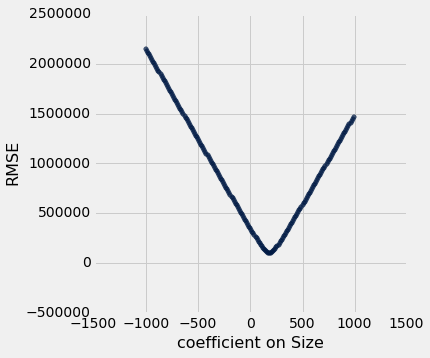

In [9]:
# Just run this cell.  It computes a bunch of slopes for potential
# lines, then computes the root-mean-squared error for each one.
# The best line for this dataset, a.k.a. the least-squares
# regression line, is the one where the RMSE is smallest.
slopes = Table().with_column("coefficient on Size", np.arange(-1000, 1000, 10))
objective_function = make_least_squares_objective_function(train.select("Size"), train.column("Price"))
def objective_value_for_slope(slope):
    return objective_function(np.array([slope]))
errors = slopes.with_column("RMSE", slopes.apply(objective_value_for_slope, "coefficient on Size"))
errors.scatter("coefficient on Size", "RMSE")

**Question 1.2.** Using the plot, what do you think the optimal coefficient is for Size in this regression, roughly?  Round to the nearest 100.

In [12]:
optimal_size_coefficient =  200

In [13]:
_ = lab09.grade("q12")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



The next cell shows how to compute an array containing the slope of a regression of house price on house size.  There's no intercept, so our predictions using this very simple model are:

    predicted price = house size * just_size_coefficients.item(0)

If we see a new house that's 1000 square feet in size, and our coefficient is 200 (actually, it's technically 200 dollars per square foot), then we'd predict it costs \$200,000.  That's just a prediction, of course.  If it actually costs \$160,000, then our prediction error was \$40,000 for that house.

In [14]:
# Just run this cell.
# Here we compute the slope for a simple linear regression of price on
# size, with no intercept.
just_size = train.select(["Price", "Size"])
just_size_coefficients = least_squares_coefficients(just_size, "Price")

We saw in class that it's not a good idea to test how well a model does on the data we used to train it.  The line will work artificially well on the training data (`just_size`), compared to other similar houses whose prices we might be interested in predicting.

**Question 1.3.** In the next cell, to compute the *predicted prices* and *prediction errors* for each house in `test`.

*Hint:* If you read and understand `predict_all`, your answer could be very short.

In [15]:
# You can fill in this variable if you want.  It should be
# a table of the feature values (not the prices) for all
# the houses in the test set.  This will be useful in the
# next two lines.
just_size_test = 

# Compute the predictions for every house in the test table.
# FILL THIS PART IN.  You can add more lines if you want.
just_size_test_predictions = 

# Compute the errors for every house in the test table.
# FILL THIS PART IN.  You can add more lines if you want.
just_size_test_errors = 

SyntaxError: invalid syntax (<ipython-input-15-b2dac6b0eb18>, line 5)

In [16]:
_ = lab09.grade("q13")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Question > Suite 1 > Case 1

>>> # It looks like you're computing predictions of the prices of
>>> # houses in the training set.  Instead, we wanted to compute
>>> # predictions of the prices of houses in the *test* set.
>>> # Make a table similar to just_size, but based on the table
>>> # called test.
>>> len(just_size_test_predictions) != 300
NameError: name 'just_size_test_predictions' is not defined

# Error: expected
#     True
# but got
#     NameError

---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



Run the next cell to see a plot of the errors our model makes on the test set, which you just computed.

In [204]:
# Just run this cell.
# Here's a plot of the test errors.
Table().with_columns(["Size", test.column("Size"), "Predicted price", just_size_test_predictions]).scatter(0, 1, color="blue", label="Predicted prices")
plt.scatter(test.column("Size"), test.column("Price"), color="red", zorder=0, label="Actual prices")
plt.legend()
plt.title("Predicted and actual prices")

# And here's a plot of the errors.
Table().with_columns([
        "Size", test.column("Size"),
        "Error", just_size_test_errors
    ]).scatter(0, 1, color="red")
plt.title("Errors on test set")

A plot like the one above is useful, but there are other things we'd like to know about a regression.  The cell below defines a function called `display_errors` that displays some information about the errors made by a regression model.  Read the documentation for `display_errors` and run the cell:

In [205]:
def r_squared(errors, true_values):
    """
    Computes the R-squared value (the correlation, but for multiple
    regression, and squared) for a regression model when it produces
    certain errors.  So errors should be an array of numbers, one for
    each row in some data table for which we're computing predictions
    (that is, each house).  Each number is the prediction error of a
    regression model (when predicting the price of a house).  true_values
    should also be an array of numbers (the true price of each house).
    """
    return 1 - np.var(errors)/np.var(true_values)

def display_errors(data, predicted_column_name, coefficients):
    """
    After computing regression coefficients, we often want to investigate
    various aspects of the regression.  This function displays some
    information about the errors made by a regression model on the dataset
    in the data table:
    * A histogram of the errors.
    * The root mean squared error of the regression.
    * The R-squared value of the regression.  (That's like the square of
      the correlation, so it's between 0 and 1, and larger values mean
      the model made better predictions for these data.)
    
    The arguments are:
    1. The dataset on which we want to examine errors, like a training
       set to examine training residuals, or a test set to examine
       errors on the population.  It should contain one column for each
       feature, plus a column for the values we're trying to predict.
       Each row should represent one house.
    2. The name of the column in that table with the values we're trying
       to predict (e.g. "Price").
    3. An array of the coefficients produced by a linear regression,
       one for each column in the data table other than
       predicted_column_name.
    """
    features_table = data.drop(predicted_column_name)
    true_values = data.column(predicted_column_name)
    errors = compute_errors(features_table, coefficients, true_values)
    print("RMSE: ", rmse(errors))
    print("R-squared: ", r_squared(errors, true_values))
    
    # Make a histogram of the errors:
    biggest_error = max(errors)
    smallest_error = min(errors)
    num_ticks = int(len(errors) / 10)
    bin_width = (biggest_error - smallest_error) / num_ticks
    Table().with_column("error", errors).hist(bins=np.arange(smallest_error, biggest_error + bin_width, bin_width))

**Question 1.4.** In the next cell, use `display_errors` to display information about the *training-set residuals* of the regression of price on size.

*Hint:* The training-set residuals are different from the errors you computed in question 1.3.  Training-set residuals are the errors on the training data.

In [206]:
...

**Question 1.5.** Now use `display_errors` to display information about the *test-set errors* of the regression of price on size.  (You computed those errors in question 1.3.)  Note whether the R-squared is smaller or larger than the R-squared on the training set.  Like correlation, a larger R-squared means that the model fits the data better.  How can you explain what you see?

In [207]:
...

**Question 1.6.** If the data were generated from the simple regression model we saw in class, the errors would be roughly bell-shaped and symmetric about 0.  Is that the case here, or are the errors skewed in one direction?

*Write your answer here, replacing this text.*

**Question 1.7.** Now let's do a multiple regression.  Use `least_squares_coefficients` to compute the coefficients for a linear regression of price on *all* the columns of `train`.  This will take about a minute to run.

In [208]:
# Set coefficients to the coefficients of a least-squares linear
# regression of price on all the columns of the train table.
coefficients = ...
coefficients

In [209]:
_ = lab09.grade("q16") # Apologies for the incorrect numbering.

**Question 1.8.** Using `display_errors`, display the residuals (the errors of the model on the data in `train`) and the test errors (the errors of the model on the data in `train`).  

In [210]:
...
...

**Question 1.9.** Are the errors smaller or larger for this model than for the model that used only size to predict prices?

*Write your answer here, replacing this text.*

**Question 1.10.** Is the error smaller for the training set or for the test set?

*Write your answer here, replacing this text.*

**Question 1.11.**  When we have a lot of coefficients, we have to do a bit of work to visualize them properly.  In the next cell, we've outlined a function called `display_coefficients` that displays some information about the coefficients produced by a regression.  Fill it in with code that matches the documentation.

In [211]:
# Fill in the body of this function:
def display_coefficients(coefficient_labels, coefficients):
    """
    After computing regression coefficients, we often want to investigate
    various aspects of the regression.  This function displays information
    about the coefficients we found for each feature:
    * A table of coefficients (using show()), with a column for the
      labels of the coefficients (e.g. "Bedrooms") and a column for the
      coefficient values.
    * A bar chart of the coefficients, with one bar for each coefficient,
      labeled with its label (e.g. "Bedrooms").
    
    coefficient_labels is an array of strings, a name for each element
    of the coefficients array.
    
    coefficients is an array of numbers, one for each feature in some
    regression we've done.
    """
    # Our solution makes a table called coefficient_table, but you
    # don't have to do that.
    coefficient_table = ...
    ...
    ...

# This will call your function on the coefficients you just learned.
display_coefficients(train.drop("Price").labels, coefficients)

A house sold in Arroyo Grande has a 0 for all the location columns other than "Arroyo Grande (0/1)" and a 1 for that column.  So the prediction for that house's price looks like:
    
    bedroom coefficient * # of bedrooms +
    bathroom coefficient * # of bathrooms + 
    size coefficient * size +
    Santa Maria-Orcutt coefficient * 0 + 
    Paso Robles coefficient * 0 + 
    ...
    Arroyo Grande coefficient * 1 + 
    Lompoc coefficient * 0 + 
    ...
    San Miguel coefficient * 0
    
This gives a nice interpretation for the Arroyo Grande coefficient.  We just add it to the predicted price of houses in Arroyo Grande, and for those houses we don't add the other location coefficients.

**Question 1.12.** What is the difference between the predicted price of a house in Arroyo Grande and the predicted price of a house with the same physical characteristics in Santa Maria-Orcutt, using the coefficients we've found?

In [212]:
predicted_price_difference = ...
predicted_price_difference

In [213]:
_ = lab09.grade("q111") # Apologies for the incorrect numbering.

After seeing this data, would you now be surprised to learn that Arroyo Grande is much more affluent than Santa Maria?

In [214]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [lab09.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

In [215]:
# Run this cell to submit your work *after* you have passed all of the test cells.
# It's ok to run this cell multiple times. Only your final submission will be scored.

!TZ=America/Los_Angeles ipython nbconvert --output=".lab09_$(date +%m%d_%H%M)_submission.html" lab09.ipynb && echo "Submitted successfully."